# Title: Movie Rating Prediction

### Goal:

The objective of my project is to build a recommender systems that can predict the rating of a movie from the previous user rating. To achive the goal I implement collaborative filtering apporach. I also split my data set into train and test (80-20) data. I calculate the RMSE value from prediction result, and the actual rating. After that I also measure the relation between number of neighbhor user (k), Root Mean Square Error (RMSE), and process time.

### Datasets:

#### I have worked with a movie data set downloaded from kaggle. The lik of the data set is: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings_small.csv

In [1]:
import numpy as np
import pandas as pd
import timeit
from scipy.spatial import distance
import math
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('dswf_ss_22_p1_input_data.csv')
df.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
# ceate all uniqe user and movies id

all_unique_user = sorted(list(set(list(df['userId']))))
all_unique_mvid = sorted(list(set(list(df['movieId']))))

In [5]:
print(f'Total Unique User: {len(all_unique_user)}')
print(f'Total Unique Movies: {len(all_unique_mvid)}')

Total Unique User: 671
Total Unique Movies: 9066


In [6]:
grp_df = df.groupby('userId')

In [7]:
# create train and test data set
st_time = timeit.default_timer()

train_data = []
test_data = []

for uid, uid_df in grp_df:
    
    all_indices = list(range(len(uid_df)))
    total_ids = len(all_indices)
    
    grp_movies = list(uid_df['movieId'])
    grp_ratings = list(uid_df['rating'])
   
    # get 80% data as training
    total_train_id = round(total_ids * 0.8)
    
    # randomly suffle all the indices
    np.random.shuffle(all_indices)
    
    for i in range(len(all_indices)):
        if i < total_train_id:
            train_data.append([uid, grp_movies[all_indices[i]], grp_ratings[all_indices[i]]])
        else:
            test_data.append([uid, grp_movies[all_indices[i]], grp_ratings[all_indices[i]]])
            # set -1 to those data which we eant to test
            train_data.append([uid, grp_movies[all_indices[i]], 0])
    
train_df = pd.DataFrame(train_data, columns=['user_id', 'movie_id', 'rating'])
test_df = pd.DataFrame(test_data, columns=['user_id', 'movie_id', 'rating'])

print(f'Total number of train data points: {len(train_df)}')
print(f'Total number of test data points : {len(test_df)}')
print(f'\nComputation time needed: {timeit.default_timer()-st_time} sec.')

Total number of train data points: 100004
Total number of test data points : 20003

Computation time needed: 0.24698399999999998 sec.


In [9]:
train_df

,user_id,movie_id,rating
0,1,1343,2.0
1,1,2455,2.5
2,1,1287,2.0
3,1,1371,2.5
4,1,1129,2.0
...,...,...,...
99999,671,432,0.0
100000,671,1196,0.0
100001,671,2194,0.0
100002,671,3897,0.0


In [10]:
test_df

,user_id,movie_id,rating
0,1,2193,2.0
1,1,3671,3.0
2,1,2968,1.0
3,1,1061,3.0
4,2,474,2.0
...,...,...,...
19998,671,432,2.5
19999,671,1196,5.0
20000,671,2194,3.5
20001,671,3897,2.0


In [13]:
# create training matrix

st_time = timeit.default_timer()

grp_data = train_df.groupby("movie_id")

t = 0

# final output data
final_data = []
train_movie_ids = []

for mid, mid_df in grp_data:
    if t>0 and t%1000 == 0:
        print(f'process {t}-th movie running ... ... ...')
    
    t += 1
        
    # init all users with NaN
    data_v = np.empty(np.max(all_unique_user))
    data_v[:] = np.NaN
    
    uids = list(mid_df['user_id'])
    ratings = list(mid_df['rating'])
    
    for i in range(len(uids)):
        # add rating for each user
        data_v[uids[i]-1] = ratings[i]
    
    train_movie_ids.append(mid)
    final_data.append(data_v)
    
print(f'All data proceed succesfully ... ... ...')

# now data is movie_id x user_id form, transpose it to user_id x movie_id format
final_data_t = np.array(final_data).T

# make new data frame where each row represent user_id and each column represent movie_id
new_training_df = pd.DataFrame(final_data_t, columns=train_movie_ids, index=all_unique_user)

print(f'Total number of rows= {len(new_training_df)}')
et_time =  timeit.default_timer()

print(f'\nComputation time needed: {et_time-st_time} sec.')

process 1000-th movie running ... ... ...
process 2000-th movie running ... ... ...
process 3000-th movie running ... ... ...
process 4000-th movie running ... ... ...
process 5000-th movie running ... ... ...
process 6000-th movie running ... ... ...
process 7000-th movie running ... ... ...
process 8000-th movie running ... ... ...
process 9000-th movie running ... ... ...
All data proceed succesfully ... ... ...
Total number of rows= 671

Computation time needed: 1.3066573999999989 sec.


In [14]:
new_training_df

,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
clean_train_data = new_training_df.fillna(0)
clean_train_data

,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
np_data = clean_train_data.to_numpy()
print(f'Shape of np data: {np.shape(np_data)}')

Shape of np data: (671, 9066)


In [ ]:
# calculate the distance matrix for each user base on the rating

st_time = timeit.default_timer()

sum_of_process_time = 0

distance_matricx = np.zeros((len(all_unique_user), len(all_unique_user)))

for ind_a in range(len(np_data)):
    
    item_s_time = timeit.default_timer()
    
    if ind_a == 1000:
        break
   
    rating_a = np_data[ind_a][:]
    #print(list(rating_a))
    
    #print(f'calculating for user: {ind_a+1}... ... ...')
    
    for ind_b in range(ind_a+1, len(np_data)):
        if ind_b==1000:
            break
        
        rating_b =  np_data[ind_b][:]
        
        # calculate the cosine difference between two vectors
        ratig_ab = distance.cosine(rating_a, rating_b)
        
        distance_matricx[ind_a][ind_b] = distance_matricx[ind_b][ind_a] = ratig_ab
                
        # print(f'Distance between {ind_a+1} and {ind_b+1} is: {ratig_ab}')
    
    item_process_time = timeit.default_timer() - item_s_time
    sum_of_process_time += item_process_time
    
    print(f'calculated time for user: {ind_a+1} is {item_process_time} sec.')

et_time =  timeit.default_timer()
print(f'\nTotal Computation time needed: {et_time-st_time} sec. and average prcoess time for each user: \
{sum_of_process_time/len(all_unique_user)} sec.')

calculated time for user: 1 is 0.11199750000000108 sec.
calculated time for user: 2 is 0.09407170000000065 sec.
calculated time for user: 3 is 0.09310070000000081 sec.
calculated time for user: 4 is 0.09809399999999613 sec.
calculated time for user: 5 is 0.09538720000000467 sec.
calculated time for user: 6 is 0.09269979999999833 sec.
calculated time for user: 7 is 0.09172759999999869 sec.
calculated time for user: 8 is 0.08714839999999668 sec.
calculated time for user: 9 is 0.08325059999999951 sec.
calculated time for user: 10 is 0.09090659999999673 sec.
calculated time for user: 11 is 0.08596130000000102 sec.
calculated time for user: 12 is 0.09401469999999534 sec.
calculated time for user: 13 is 0.09549909999999784 sec.
calculated time for user: 14 is 0.09104100000000415 sec.
calculated time for user: 15 is 0.08777249999999981 sec.
calculated time for user: 16 is 0.08988659999999982 sec.
calculated time for user: 17 is 0.08733199999999641 sec.
calculated time for user: 18 is 0.097985

calculated time for user: 146 is 0.0946514000000036 sec.
calculated time for user: 147 is 0.08191919999998731 sec.
calculated time for user: 148 is 0.08146410000000515 sec.
calculated time for user: 149 is 0.07547079999999085 sec.
calculated time for user: 150 is 0.0671810999999991 sec.
calculated time for user: 151 is 0.06654670000000351 sec.
calculated time for user: 152 is 0.06642259999999567 sec.
calculated time for user: 153 is 0.07498170000000925 sec.
calculated time for user: 154 is 0.08263969999998722 sec.
calculated time for user: 155 is 0.07989219999998909 sec.
calculated time for user: 156 is 0.07119269999999744 sec.
calculated time for user: 157 is 0.06821330000001069 sec.
calculated time for user: 158 is 0.06654620000000477 sec.
calculated time for user: 159 is 0.07941110000000151 sec.
calculated time for user: 160 is 0.08353859999999713 sec.
calculated time for user: 161 is 0.0710767000000061 sec.
calculated time for user: 162 is 0.06623890000000188 sec.
calculated time f

calculated time for user: 288 is 0.05332140000000152 sec.
calculated time for user: 289 is 0.05222969999999805 sec.
calculated time for user: 290 is 0.05723090000000752 sec.
calculated time for user: 291 is 0.05224700000000837 sec.
calculated time for user: 292 is 0.05355519999999103 sec.
calculated time for user: 293 is 0.053277500000007194 sec.
calculated time for user: 294 is 0.05270480000000077 sec.
calculated time for user: 295 is 0.05261939999999754 sec.
calculated time for user: 296 is 0.05045659999998975 sec.
calculated time for user: 297 is 0.049004000000010706 sec.
calculated time for user: 298 is 0.05249340000000302 sec.
calculated time for user: 299 is 0.04748670000000743 sec.
calculated time for user: 300 is 0.046858999999997764 sec.
calculated time for user: 301 is 0.04876620000000287 sec.
calculated time for user: 302 is 0.0541419999999988 sec.
calculated time for user: 303 is 0.05284460000000024 sec.
calculated time for user: 304 is 0.047499000000001956 sec.
calculated 

In [82]:
def rmse_calculation(a, b):
    sum = 0  
    n = len(b)
    for i in range (0, n):  
        diff = a[i] - b[i]  
        sum += (diff ** 2)  
    return math.sqrt(sum/n)

In [83]:
test_grp = test_df.groupby('user_id')

In [84]:
def main_funtion(k):
    all_mse_error = []

    for uid, grp_data in test_grp:
        if uid == 20000:
            break

        #print(grp_data)
        movie_ids = list(grp_data['movie_id'])
        original_values = list(grp_data['rating'])

        #print(movie_ids)
        # holds the predict rating
        predicted_values = []

        # pick all user other than the intended user
        similar_user = np.delete(distance_matricx[uid-1][:], uid-1)

        # get index of top k user
        similar_idx = np.argsort(similar_user)[:k]
        # print(similar_idx)

        # get distance of similar k user
        similar_user_rating = np.sort(similar_user)[:k]
        #print(similar_user_rating)

        for mv_ind in range(len(movie_ids)):
            movie_id = movie_ids[mv_ind]
            movie_index_in_data = all_unique_mvid.index(movie_id)
            
            similar_rating = 0
            matched_user = 0

            for su_ind in range(len(similar_idx)):
                similar_user = similar_idx[su_ind]
                
                if np_data[similar_user][movie_index_in_data] > 0:
                    matched_user += 1
                
                similar_rating += np_data[similar_user][movie_index_in_data]
                #print(f'similar uid= {similar_user+1} -> movie id= {movie_id} -> rating= {similar_rating}')
            
            predicted_rating = similar_rating/matched_user if (matched_user>0) else 0 
            
            predicted_values.append(predicted_rating)
            #print(f'MovieId= {movie_id} -> similar rating= {similar_rating} -> Matched User= {matched_user}')
        
        uid_mse = rmse_calculation(original_values, predicted_values)
        
        all_mse_error.append(uid_mse)
    
    return all_mse_error

In [85]:
K = list(range(5, 101, 5))

output_summary = []
total_proess_time = []

process_time = 0
for k in K:
    st_time = timeit.default_timer()
    summary_mse = main_funtion(k)
    output_summary.append(summary_mse)
    et_time = timeit.default_timer()
    
    kth_process_time = et_time-st_time
    process_time += (kth_process_time)
    
    total_proess_time.append(kth_process_time)
    
    print(f'Time needed for computing with k={k} is: {kth_process_time} sec. and average mse is: {np.mean(summary_mse)}')
    
#print(MSE)
print(f'\nAaverage prcoess time for each process: {process_time/len(K)} sec.')

Time needed for computing with k=5 is: 0.8299038999994082 sec. and average mse is: 2.6522163337679125
Time needed for computing with k=10 is: 0.9826694000003044 sec. and average mse is: 2.2150427039134906
Time needed for computing with k=15 is: 1.1239261999999144 sec. and average mse is: 1.9779175928208117
Time needed for computing with k=20 is: 1.2104639999997744 sec. and average mse is: 1.8082783714088628
Time needed for computing with k=25 is: 1.2858852999997907 sec. and average mse is: 1.6951450607710108
Time needed for computing with k=30 is: 1.4496696000005613 sec. and average mse is: 1.6034633456729692
Time needed for computing with k=35 is: 1.5796312999991642 sec. and average mse is: 1.5467636096327184
Time needed for computing with k=40 is: 1.6166298000007373 sec. and average mse is: 1.4911972064925858
Time needed for computing with k=45 is: 1.7555209000001923 sec. and average mse is: 1.446924426557874
Time needed for computing with k=50 is: 1.8040448000010656 sec. and average

In [86]:
# summarize the output

mse_data = []

for i in range(len(K)):
    k = K[i]
    kth_time  = total_proess_time[i]
    mse = output_summary[i][:]
    
    mse_min = np.min(mse)
    mse_max = np.max(mse)
    mse_avg = np.mean(mse)
    
    mse_data.append([k, mse_min, mse_avg, mse_max, kth_time])
    
summ_df = pd.DataFrame(mse_data, columns=['K', 'min. RMSE', 'avg. RMSE', 'max. RMSE', 'process_time'])

In [87]:
print(summ_df)

      K  min. RMSE  avg. RMSE  max. RMSE  process_time
0     5   0.224382   2.652216   4.852834      0.829904
1    10   0.250867   2.215043   4.505552      0.982669
2    15   0.291633   1.977918   4.157448      1.123926
3    20   0.250000   1.808278   3.933475      1.210464
4    25   0.320015   1.695145   3.704492      1.285885
5    30   0.313452   1.603463   3.670339      1.449670
6    35   0.283364   1.546764   3.538640      1.579631
7    40   0.291548   1.491197   3.532668      1.616630
8    45   0.291548   1.446924   3.530876      1.755521
9    50   0.336519   1.414713   3.530876      1.804045
10   55   0.322059   1.387204   3.529050      1.868259
11   60   0.324624   1.366600   3.528221      1.928707
12   65   0.317024   1.342386   3.449111      2.037455
13   70   0.326239   1.324269   3.434927      2.138695
14   75   0.330785   1.301649   3.269088      2.220125
15   80   0.179240   1.284703   3.268436      2.296611
16   85   0.141128   1.272612   3.250385      2.399671
17   90   

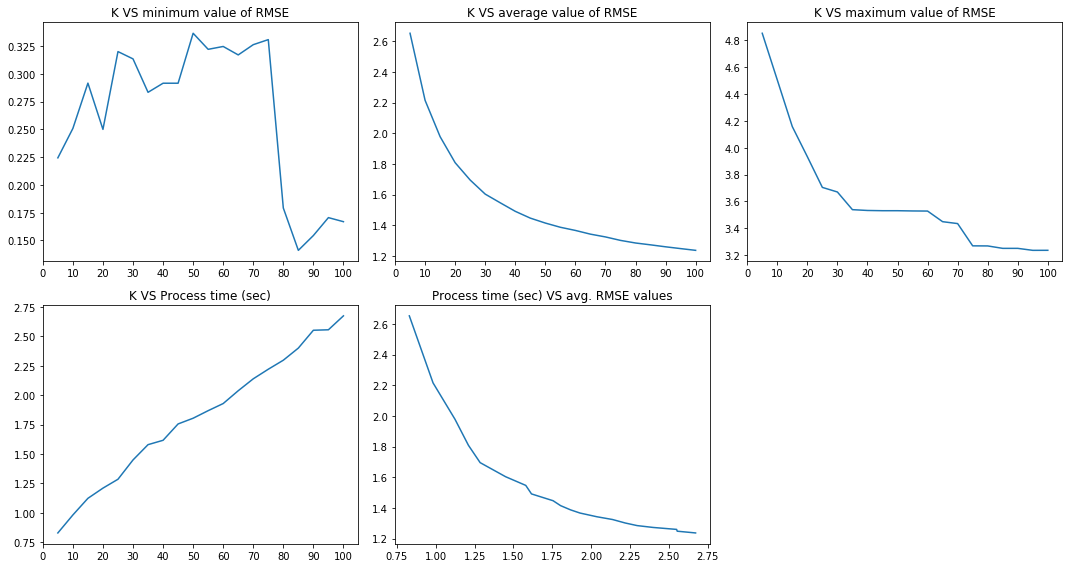

In [88]:
fig = plt.figure() 

# Figure size
fig.set_size_inches(15, 8)

# min. MSE VS K
plt.subplot(2, 3, 1)
plt.plot(summ_df['K'].values, summ_df['min. RMSE'].values)
plt.xticks(np.arange(0, 101, 10))
plt.title('K VS minimum value of RMSE')

# avg. MSE VS K
plt.subplot(2, 3, 2)
plt.plot(summ_df['K'].values, summ_df['avg. RMSE'].values)
plt.xticks(np.arange(0, 101, 10))
plt.title('K VS average value of RMSE')

# max. MSE VS K
plt.subplot(2, 3, 3)
plt.plot(summ_df['K'].values, summ_df['max. RMSE'].values)
plt.xticks(np.arange(0, 101, 10))
plt.title('K VS maximum value of RMSE')

# K VS process time
plt.subplot(2, 3, 4)
plt.plot(summ_df['K'].values, summ_df['process_time'].values)
plt.xticks(np.arange(0, 101, 10))
plt.title('K VS Process time (sec)')

# process time VS average MSE value
plt.subplot(2, 3, 5)
plt.plot(summ_df['process_time'].values, summ_df['avg. RMSE'].values)
plt.title('Process time (sec) VS avg. RMSE values')


plt.tight_layout()

plt.show()